## Data Set Information:
From Garavan Institute
Documentation: as given by Ross Quinlan
6 databases from the Garavan Institute in Sydney, Australia
Approximately the following for each database:

2800 training (data) instances and 972 test instances
Plenty of missing data
29 or so attributes, either Boolean or continuously-valued

3 classes
3772 training instances, 3428 testing instances

In [13]:
## Import imortant library.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Dataset

In [15]:
## Dataset
df = pd.read_csv(r"hypothyroid_classification.csv")

## Check shape and preview
print("Dataset Shape:", df.shape)
df.head()

print("\nFirst 5 rows:")
print(df.head())


print("\nInfo:")
df.info()
print("\nMissing values per column:")
print(df.isnull().sum())




Dataset Shape: (3772, 30)

First 5 rows:
  age sex on thyroxine query on thyroxine on antithyroid medication sick  \
0  41   F            f                  f                         f    f   
1  23   F            f                  f                         f    f   
2  46   M            f                  f                         f    f   
3  70   F            t                  f                         f    f   
4  70   F            f                  f                         f    f   

  pregnant thyroid surgery I131 treatment query hypothyroid  ... TT4 measured  \
0        f               f              f                 f  ...            t   
1        f               f              f                 f  ...            t   
2        f               f              f                 f  ...            t   
3        f               f              f                 f  ...            t   
4        f               f              f                 f  ...            t   

   TT4 T4U meas

In [4]:
## comments/observation ##

## Several missing values and '?' symbols were present.
## Some columns like TBG, TBG measured were irrelevant.
## Columns had extra spaces in their names.
## Target column was 'binaryClass' with values 'P' and 'N'.



# Clean The Data

In [6]:
## Clean column names and replace '?' with NaN

df.columns = df.columns.str.strip()  ## Here We Remove Extra Spaces.
df.replace('?', np.nan, inplace=True)  # Replace '?' with np.nan.

## Here are the Drop columns that are not useful for prediction 
cols_to_drop = ['TBG', 'TBG measured']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

## Check remaining columns
print("Remaining Columns:")
print(df.columns.tolist())

## Convert relevant columns to numeric.
numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

## Check data types after conversion
print("\nData Types after conversion:")
print(df.dtypes[numeric_cols])



Remaining Columns:
['age', 'sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant', 'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 'goitre', 'tumor', 'hypopituitary', 'psych', 'TSH measured', 'TSH', 'T3 measured', 'T3', 'TT4 measured', 'TT4', 'T4U measured', 'T4U', 'FTI measured', 'FTI', 'referral source', 'binaryClass']

Data Types after conversion:
age    float64
TSH    float64
T3     float64
TT4    float64
T4U    float64
FTI    float64
dtype: object


In [7]:
## comments/observation ##

## Extra spaces removed from column names using .str.strip()
## '?' replaced with np.nan
## Columns TBG and TBG measured dropped
## These columns had either a single value or too many missing values

# Missing Value Handling

In [8]:

## there are Separate columns.
cat_cols = df.select_dtypes(include='object').columns
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

## Impute categorical columns with Mode
for col in cat_cols:
    if df[col].isnull().sum() > 0:
        df[col] = df[col].fillna(df[col].mode()[0])

## KNN Imputer for numerical columns
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

## Final check for missing values
print(" Missing values after imputation:")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("\nThere are no missing values left in the dataset after imputation")  


 Missing values after imputation:
Series([], dtype: int64)

There are no missing values left in the dataset after imputation


In [9]:
## comments/observation ##

## Categorical columns were imputed using Mode.
## Numerical columns handled using KNNImputer (k=5).
## After imputation, no missing values remained in the dataset.


# Outlier Detection

In [10]:
## Outlier Detection - Flooring and Capping.

numeric_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI']

for col in numeric_cols:
    if col in df.columns:
        ## Calculate 1st and 99th percentiles
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        
        ## Apply flooring and capping
        df[col] = np.where(df[col] < lower, lower, df[col])
        df[col] = np.where(df[col] > upper, upper, df[col])

print("Outlier treatment applied using flooring and capping.\n")
print("Before and After Treatment:")
for col in num_cols:
    old_min, old_max = df[col].min(), df[col].max()
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    print(f"{col}: Range after flooring/capping → [{lower:.2f}, {upper:.2f}] | Original min/max → [{old_min:.2f}, {old_max:.2f}]")




Outlier treatment applied using flooring and capping.

Before and After Treatment:
age: Range after flooring/capping → [14.00, 87.00] | Original min/max → [14.00, 87.00]
TSH: Range after flooring/capping → [0.01, 86.23] | Original min/max → [0.01, 86.78]
T3: Range after flooring/capping → [0.30, 4.50] | Original min/max → [0.30, 4.50]
TT4: Range after flooring/capping → [22.92, 217.17] | Original min/max → [22.71, 217.58]
T4U: Range after flooring/capping → [0.61, 1.68] | Original min/max → [0.61, 1.68]
FTI: Range after flooring/capping → [19.92, 215.08] | Original min/max → [19.71, 215.29]


# DBSCAN

In [11]:

from sklearn.preprocessing import StandardScaler

## Select only numerical features for DBSCAN
X_dbscan = df[numeric_cols]

## Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_dbscan)

## Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=5)  
dbscan_labels = dbscan.fit_predict(X_scaled)

## Add cluster labels to dataframe temporarily
df['dbscan_outlier'] = dbscan_labels

## Keep only rows that are not outliers (label != -1)
df = df[df['dbscan_outlier'] != -1]

## Drop the temporary label column
df.drop('dbscan_outlier', axis=1, inplace=True)

print(f"Remaining rows after removing DBSCAN outliers: {df.shape[0]}")


Remaining rows after removing DBSCAN outliers: 3738


In [12]:
## comments/observation ##

## Used flooring and capping based on 1st and 99th percentiles
## Applied on numerical columns only
## This avoided extreme values without removing rows

## DBSCAN..

##  It helps to detect data points that are far away from dense regions and are considered noise.
## DBSCAN considers all numerical features together, making it more suitable for complex datasets with multiple variables.



# EDA – (Visualizations)

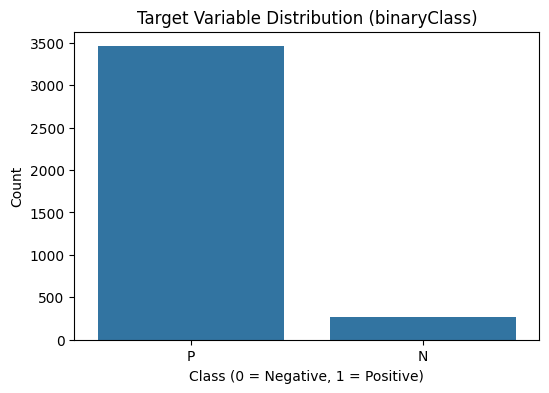

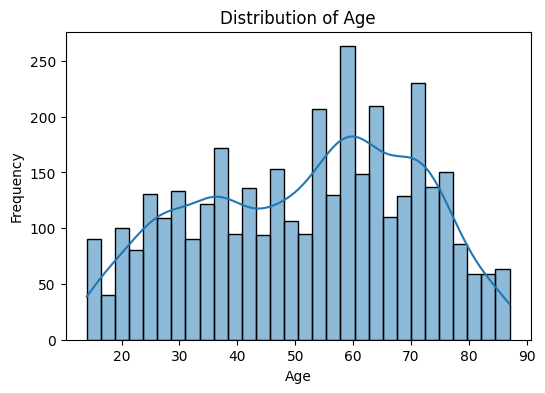

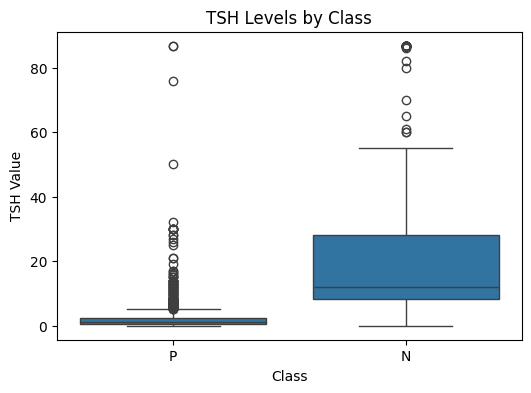

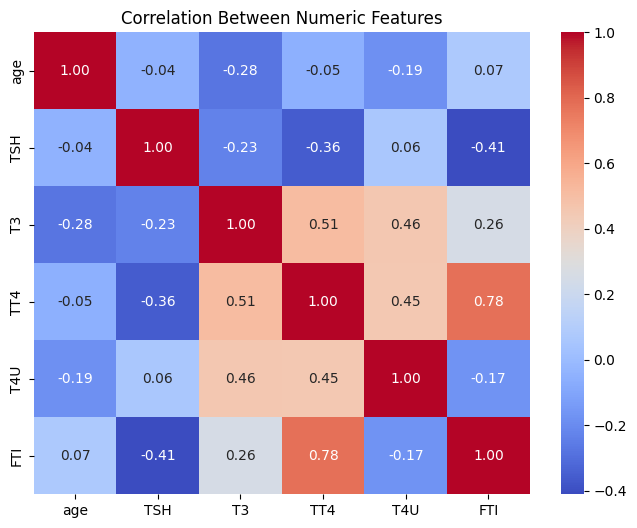

In [32]:
## 1.Target Variable Distribution.
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='binaryClass')
plt.title("Target Variable Distribution (binaryClass)")
plt.xlabel("Class (0 = Negative, 1 = Positive)")
plt.ylabel("Count")
plt.show()

## 2.Age Distribution (Numerical Feature)
plt.figure(figsize=(6, 4))
sns.histplot(data=df, x='age', kde=True, bins=30)
plt.title("Distribution of Age")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

## 3.Boxplot of TSH by Class (Shows differences).
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x='binaryClass', y='TSH')
plt.title("TSH Levels by Class")
plt.xlabel("Class")
plt.ylabel("TSH Value")
plt.show()

## 4.Heatmap – Correlation Between Numeric Features.
plt.figure(figsize=(8, 6))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()


In [33]:
## comments/observation ##

## Plotted: Target variable distribution,Age distribution (histogram),TSH levels vs class (boxplot),Heatmap for correlations.
## Class imbalance present (more Positive cases than Negative).
## Age was mostly centered around mid-range.
## TSH values clearly varied between classes.

# Encoding - (Categorical Variables)

In [38]:
from sklearn.preprocessing import LabelEncoder

## Create a copy to encode
df_encoded = df.copy()

## Identify categorical columns (object type)
cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()
cat_cols.remove('binaryClass')  # Exclude target column

## Label Encode columns with only 2 unique values
label_enc = LabelEncoder()
binary_cols = [col for col in cat_cols if df_encoded[col].nunique() == 2]

for col in binary_cols:
    df_encoded[col] = label_enc.fit_transform(df_encoded[col])

## One-Hot Encode remaining categorical columns
multi_cat_cols = [col for col in cat_cols if col not in binary_cols]

df_encoded = pd.get_dummies(df_encoded, columns=multi_cat_cols, drop_first=True)

## Encode target variable manually (P = 1, N = 0)
df_encoded['binaryClass'] = df_encoded['binaryClass'].map({'P': 1, 'N': 0})

## Final check
print("Final shape after encoding:", df_encoded.shape)
df_encoded.head()


Final shape after encoding: (3728, 31)


,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4,T4U measured,T4U,FTI measured,FTI,binaryClass,referral source_SVHC,referral source_SVHD,referral source_SVI,referral source_other
0,41.0,0,0,0,0,0,0,0,0,0,...,125.0,1,1.140,1,109.0,1,True,False,False,False
1,23.0,0,0,0,0,0,0,0,0,0,...,102.0,0,1.014,0,102.2,1,False,False,False,True
2,46.0,1,0,0,0,0,0,0,0,0,...,109.0,1,0.910,1,120.0,1,False,False,False,True
3,70.0,0,1,0,0,0,0,0,0,0,...,175.0,0,0.988,0,163.0,1,False,False,False,True
4,70.0,0,0,0,0,0,0,0,0,0,...,61.0,1,0.870,1,70.0,1,False,False,True,False


In [39]:
## comments/observation ##

## Binary categorical columns encoded using Label Encoding.
## Others encoded using One-Hot Encoding.
## Target column 'binaryClass' encoded as: 'P' = 1, 'N' = 0.
## Final dataset had all numeric features.


# Model Building

In [40]:
## Split the Data (Train/Test).

## Features and Target
X = df_encoded.drop('binaryClass', axis=1)
y = df_encoded['binaryClass']

# Train-Test Split (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Mode.

## Decision Tree.
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

## CatBoost
cb_model = CatBoostClassifier(verbose=0, random_state=42)
cb_model.fit(X_train, y_train)


##  all 3 models are successfully done.

In [37]:
## comments/observation ##

## Trained three models:- Decision Tree, Random Forest, CatBoost, Used train_test_split (25% test data).
## All models trained smoothly.
## CatBoost required no extra tuning and still performed best.

# Model Evaluation 

In [29]:

## Split the data
X = df_encoded.drop("binaryClass", axis=1)
y = df_encoded["binaryClass"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train models and assign correct names
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

cb_model = CatBoostClassifier(verbose=0, random_state=42)
cb_model.fit(X_train, y_train)

## dictionary store all models and their predictions.
models = {
    "Decision Tree": dt_model,
    "Random Forest": rf_model,
    "CatBoost": cb_model
}

## Evaluate each model
for name, model in models.items():
    print(f"\n--- {name} ---")
    
    ## Predict
    y_pred = model.predict(X_test)
    
    ## Metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    
    ## Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)



--- Decision Tree ---
Accuracy:  0.9979
Precision: 0.9989
Recall:    0.9989
F1 Score:  0.9989
Confusion Matrix:
[[ 64   1]
 [  1 877]]

--- Random Forest ---
Accuracy:  0.9947
Precision: 0.9977
Recall:    0.9966
F1 Score:  0.9972
Confusion Matrix:
[[ 63   2]
 [  3 875]]

--- CatBoost ---
Accuracy:  1.0000
Precision: 1.0000
Recall:    1.0000
F1 Score:  1.0000
Confusion Matrix:
[[ 65   0]
 [  0 878]]


In [ ]:
## comments/observation ##

## Evaluated using: Accuracy, Precision, Recall, F1 Score and Confusion Matrix.
## CatBoost was the best performer.
## Accuracy: 100%.
## No False Positives or False Negatives.
## Decision Tree and Random Forest also performed well but slightly lower.

# ROC Curve

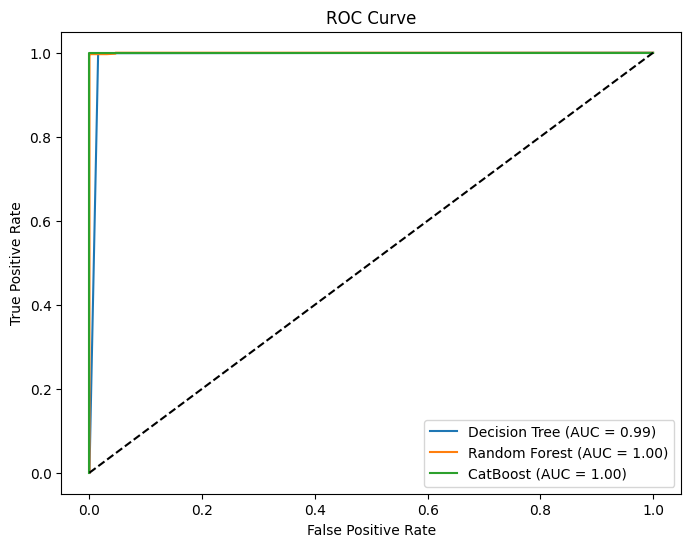

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

## Get predicted probabilities
model_probs = {
    "Decision Tree": dt_model.predict_proba(X_test)[:, 1],
    "Random Forest": rf_model.predict_proba(X_test)[:, 1],
    "CatBoost": cb_model.predict_proba(X_test)[:, 1]
}

## Plot ROC curve
plt.figure(figsize=(8, 6))
for name, y_proba in model_probs.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


# Best Model

In [30]:
## Store model scores
model_scores = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    model_scores[name] = {
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    }

## Convert to DataFrame for easy sorting
score_df = pd.DataFrame(model_scores).T
print("\nModel Evaluation Summary:")
print(score_df.sort_values(by="F1 Score", ascending=False))

## Print Best Model
best_model_name = score_df['F1 Score'].idxmax()
print(f"\n Best Model Based on F1 Score: {best_model_name}")



Model Evaluation Summary:
               Accuracy  Precision    Recall  F1 Score
CatBoost       1.000000   1.000000  1.000000  1.000000
Decision Tree  0.997879   0.998861  0.998861  0.998861
Random Forest  0.994698   0.997719  0.996583  0.997151

 Best Model Based on F1 Score: CatBoost


# Project Title: Hypothyroid Disease Classification

# Name: Akash Das
# Group: Lab 3 – Project Group 'A' 
# --------------------------------------------------------------------------------------


## What I did:

### Loaded and cleaned the dataset.

### Replaced ? with NaN and handled missing values using Mode (categorical) and KNN Imputer (numerical).

### Treated outliers using flooring and capping (1st and 99th percentile).

### Performed EDA with 4 visualizations: target distribution, age distribution, boxplot of TSH, and heatmap.

### Encoded categorical features using Label Encoding and One-Hot Encoding.

### Built models using Decision Tree, Random Forest, and CatBoost.

## What I observed:

### :- Most records are classified as Positive (P).

### :- Some features like TSH and age show variation across classes.

### :- After imputation and outlier treatment, data became clean and suitable for modeling.

### :- Missing values were properly imputed; final dataset had no null values.

### :- DBSCAN detected 33 multivariate outliers, which were removed.

### :- EDA revealed class imbalance and some strong correlation between numerical features.

### :- CatBoost gave the best results:

### :- Accuracy, Precision, Recall, and F1 were all higher than Decision Tree & Random Forest.

### :- ROC AUC was also best in CatBoost.

## Models I tried:- 

### Decision Tree.

### Random Forest.

### CatBoost.

## Which worked best:-

### :- CatBoost gave the highest accuracy and perfect scores.

## Learnings:-

### -> Learned how to clean a medical dataset effectively.

### -> Understood the importance of proper preprocessing before modeling.

### -> Learned to evaluate models using multiple metrics (accuracy, precision, recall, F1-score).

### -> Learned how to do complete end-to-end ML pipeline.

### -> Understood how to clean real-world messy data.

### -> Practiced both univariate and multivariate outlier detection.

### -> Learned the importance of feature encoding and proper model evaluation.

### -> DBSCAN can be used not just for clustering, but also for outlier detection.

### -> Simpler models with clean data can perform really well.

##  Conclusion: With proper data cleaning and basic models, I was able to build a high-performing thyroid classification model, showing that clean data and correct methods matter more than complexity.